# Checkpoint 2: Vocalization Feature Analysis/EDA for Non-Verbal Communication

This notebook supports our broader project goal of developing techniques to detect and classify non-verbal vocalizations from autistic individuals.

Specifically, this notebook focuses on:

- Extracting acoustic features (e.g., pitch, MFCCs, spectrograms) from labeled vocal samples
- Running statistical hypothesis tests to assess whether these features meaningfully differ across expressive intent labels (e.g., "yes" vs. "no", "frustrated" vs. "delighted")
- Guiding downstream model development by identifying discriminative features that could improve classification performance

The insights gained here help inform which audio characteristics are most relevant for modeling and how they correlate with the communicative intent behind each vocalization.


In [78]:
# ------------- imports ------------- #
import polars as pl
import pandas as pd
import numpy as np
import scipy
import scipy.stats
import pickle
import librosa
import scipy.signal as signal
import soundfile as sf 
from typing import Union, List, Dict, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
import warnings
import os
from concurrent.futures import ThreadPoolExecutor

## Preprocessing Overview

Before conducting any analysis or modeling, we perform a series of preprocessing steps to ensure all audio data is clean, standardized, and feature-rich. The goal is to prepare vocalization data from non-verbal individuals in a format suitable for feature extraction and machine learning workflows.

---

### 1. Audio Cleaning
Raw audio signals are passed through a customizable cleaning pipeline that includes:

- **Normalization** – Scales amplitude values to a consistent range.
- **Noise Reduction** – Uses spectral gating to remove background noise.
- **Silence Removal** – Removes low-energy segments using a dB threshold and frame-based segmentation.
- **High-pass Filtering** – Reduces low-frequency hum and background noise.

Optionally, the pipeline can **save both original and cleaned audio** for manual inspection.



### 2. File Renaming & Metadata Generation
Audio files are renamed using a consistent format:  
`<Participant>_<Label>_<Index>.wav`  
This enables easier traceability and lookup. The updated metadata is saved to a new CSV for downstream use.



### 3. Feature Extraction – Mel Spectrograms
Each cleaned audio waveform is converted into a **Mel spectrogram** (a time–frequency representation). We ensure consistency across samples by:

- Using a fixed number of **Mel bands** (default: 128)
- **Normalizing** each spectrogram using either:
  - **Sample-level statistics** (mean/std or min/max per sample), or  
  - **Global dataset statistics** (computed and optionally saved)
- **Padding or cropping** spectrograms to a fixed temporal length for modeling



### 4. Final Dataset Output
The resulting dataset includes:

- Cleaned waveform (`Audio`)
- Metadata (`Label`, `Participant ID`, `Filename`, etc.)
- Normalized spectrogram (`Spectrogram`)

This processed data is returned as a **Polars DataFrame**, with an option to save in `.pkl` format (CSV is avoided due to unsupported nested data types like arrays).

---

### Purpose
These steps prepare the dataset for robust feature-based analysis and downstream ML/DL pipelines. The goal is to ensure that audio representations are:

- Noise-free and consistent  
- Normalized across the dataset  
- Aligned in shape and scale  
- Ready for hypothesis testing, embedding, or classification


In [37]:
# ----------------------- macros ----------------------- #
SAMPLE_RATE = 441e2
ORG_CSV_PATH = './ReCANVo/dataset_file_directory.csv'
RENAME_CSV_PATH = './ReCANVo/renamed_metadata.csv'
AUDIO_DIR = './ReCANVo/'
np.random.seed(42)  # Reproducible sampling

# ----------------------- preprocessing functions ----------------------- #
def rename_audio_files(csv_path: str,
                       audio_dir: str,
                       output_csv: str = "renamed_metadata.csv") -> None:
    """
    Renames audio files based on Participant and Label and saves new metadata.

    Args:
        csv_path (str): Path to the input metadata CSV.
        audio_dir (str): Directory containing audio files.
        output_csv (str): Filename for the output metadata CSV.
    """
    df = pl.read_csv(csv_path)
    renamed_files = []
    file_counts = {}

    for file in df.iter_rows(named=True):
        org_name = file['Filename']
        id = file['Participant']
        label = file['Label']

        key = (id, label)
        file_counts[key] = file_counts.get(key, 0) + 1
        index = file_counts[key]

        new_name = f"{id}_{label}_{index}.wav"
        old_path = os.path.join(audio_dir, org_name)
        new_path = os.path.join(audio_dir, new_name)

        if not os.path.exists(old_path):
            print(f"❌ File not found: {old_path}. Skipping renaming process.")
            return  # Exit the function immediately if any file is missing

        os.rename(old_path, new_path)
        renamed_files.append((new_name, id, label, index))

    # If renaming was successful, save the updated metadata
    renamed_df = pl.DataFrame(renamed_files, schema=["Filename", "ID", "Label", "Index"], orient="row")
    output_path = os.path.join(audio_dir, output_csv)
    renamed_df.write_csv(output_path)
    
def save_audio_comparison(original_y: np.ndarray, 
                           cleaned_y: np.ndarray, 
                           sr: int, 
                           filename: str, 
                           output_dir: str = 'audio_comparisons') -> None:
    
    os.makedirs(output_dir, exist_ok=True)
    base_name = os.path.splitext(filename)[0]
    original_path = os.path.join(output_dir, f"{base_name}_original.wav")
    cleaned_path = os.path.join(output_dir, f"{base_name}_cleaned.wav")

    sf.write(original_path, original_y, sr)
    sf.write(cleaned_path, cleaned_y, sr)


def clean_audio(y: np.ndarray, 
                sr: int, 
                denoise: bool = True, 
                remove_silence: bool = True,
                normalize: bool = True,
                min_silence_duration: float = 0.3,
                silence_threshold: float = -40) -> np.ndarray:
    """
    Enhanced audio cleaning function tailored for voice recordings of autistic individuals.

    Parameters:
        y (np.ndarray): Input audio time series
        sr (int): Sampling rate
        denoise (bool): Apply noise reduction
        remove_silence (bool): Remove long silent segments
        normalize (bool): Normalize audio amplitude
        min_silence_duration (float): Minimum duration of silence to remove (in seconds)
        silence_threshold (float): Decibel threshold for silence detection

    Returns:
        np.ndarray: Cleaned audio time series
    """
    if len(y) == 0:
        return y  # Return empty if the input is empty

    cleaned_audio = y.copy()

    if normalize:
        cleaned_audio = librosa.util.normalize(cleaned_audio)

    # Noise reduction using spectral gating
    if denoise:
        stft = librosa.stft(cleaned_audio)   # Compute STFT with valid n_fft
        mag, phase = librosa.magphase(stft)               # Magnitude and phase
        noise_threshold = np.median(mag) * 0.5
        mask = mag > noise_threshold                      # Apply noise threshold mask
        cleaned_stft = stft * mask                        
        cleaned_audio = librosa.istft(cleaned_stft)       # Convert back to time domain

    # Remove long silent segments
    if remove_silence:
        frame_length = int(sr * min_silence_duration)
        hop_length = max(1, frame_length // 2)  # Ensure hop_length is at least 1

        non_silent_frames = librosa.effects.split(
            cleaned_audio, 
            top_db=abs(silence_threshold), 
            frame_length=frame_length, 
            hop_length=hop_length
        )

        if len(non_silent_frames) == 0:
            return np.array([])  # Return empty if all frames are silent

        cleaned_audio = np.concatenate([
            cleaned_audio[start:end] for start, end in non_silent_frames
        ])

    # Apply high-pass filter to reduce low-frequency noise
    b, a = signal.butter(6, 80 / (sr/2), btype='high')
    cleaned_audio = signal.filtfilt(b, a, cleaned_audio)

    return cleaned_audio


def load_audio_metadata(csv_path: str,
                        audio_dir: str,
                        limit: Union[int, None] = None,
                        clean_audio_params: dict = None,
                        save_comparisons: bool = False,
                        comparison_dir: str = 'audio_comparisons') -> pl.DataFrame:
    """
    Loads audio metadata and processes files in parallel.
    
    Args:
        csv_path (str): Path to CSV file with metadata.
        audio_dir (str): Directory where audio files are stored.
        limit (int, optional): Number of rows to load.
        clean_audio_params (dict, optional): Parameters for cleaning.
        save_comparisons (bool): Save original vs cleaned audio files.
        comparison_dir (str): Directory for saved audio comparisons.
    
    Returns:
        pl.DataFrame: DataFrame with processed audio metadata.
    """
    
    df = pl.read_csv(csv_path).drop_nulls(subset=['Filename'])

    if limit:
        df = df.head(limit)

    # Default audio cleaning parameters
    default_clean_params = {
        'denoise': True,
        'remove_silence': True,
        'normalize': True,
        'min_silence_duration': 0.3,
        'silence_threshold': -40
    }
    clean_params = {**default_clean_params, **(clean_audio_params or {})}

    # Prepare file processing queue 
    file_info_list = [
        (row['Filename'], 
         os.path.join(audio_dir, row['Filename']), 
         clean_params, 
         save_comparisons, 
         comparison_dir, 
         row['ID'],
         row['Label'],  
         row['Index']) 
        for row in df.iter_rows(named=True)
    ]

    # Modify process_audio_file to handle the additional parameters
    def process_audio_file(file_info: Tuple[str, str, dict, bool, str, int, str, int]) -> Union[Tuple[str, List[float], int, str, float, int], None]:
        """
        Loads and processes an audio file.

        Args:
            file_info (Tuple): Contains filename, full path, cleaning params, saving options, ID, Label, and Index.

        Returns:
            Tuple[str, List[float], int, str, float, int] | None: Processed audio metadata or None if failed.
        """
        file_name, file_path, clean_params, save_comparisons, comparison_dir, file_id, label, index = file_info

        y, sr = librosa.load(file_path, sr=SAMPLE_RATE)  
        cleaned_y = clean_audio(y, sr, **clean_params)

        if save_comparisons:
            save_audio_comparison(y, cleaned_y, sr, file_name, comparison_dir)

        duration = len(cleaned_y) / sr
        return file_name, cleaned_y.tolist(), file_id, label, duration, index  

    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        results = list(executor.map(process_audio_file, file_info_list))

    # Filter out None values from failed processing
    audio_data = [res for res in results if res]

    return pl.DataFrame(audio_data, schema=["Filename", "Audio", "ID", "Label", "Duration", "Index"], orient='row')


def compute_or_load_global_stats(ys: List[np.ndarray],
                                 sr: int=SAMPLE_RATE,
                                 n_mels: int = 128,
                                 method: str = "zscore",
                                 stats_file: str = "global_stats.json",
                                 force_recompute: bool = False) -> Dict[str, float]:
    """
    Computes or loads global normalization stats for Mel spectrograms.

    Parameters:
        ys (List[np.ndarray]): List of raw audio waveforms.
        sr (int): Sample rate.
        n_mels (int): Number of Mel bands.
        method (str): 'zscore' or 'minmax'.
        stats_file (str): Path to save/load stats JSON.
        force_recompute (bool): If True, recomputes even if file exists.

    Returns:
        Dict[str, float]: Stats dictionary (mean/std or min/max).
    """

    if not force_recompute and os.path.exists(stats_file):
        print(f"🗂️ Loading global stats from {stats_file}")
        with open(stats_file, "r") as f:
            return json.load(f)

    print(f"📊 Computing global stats with method '{method}'...")
    all_values = []

    for y in ys:
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        S_db = librosa.power_to_db(S, ref=np.max)
        all_values.append(S_db.flatten())

    all_values = np.concatenate(all_values)
    stats = {}

    if method == "zscore":
        stats = {
            "mean": float(np.mean(all_values)),
            "std": float(np.std(all_values))
        }
    elif method == "minmax":
        stats = {
            "min": float(np.min(all_values)),
            "max": float(np.max(all_values))
        }
    else:
        raise ValueError("Unsupported method. Use 'zscore' or 'minmax'.")

    # Save stats to file
    with open(stats_file, "w") as f:
        json.dump(stats, f)
        print(f"💾 Saved global stats to {stats_file}")

    return stats


def audio_to_spectrogram(y: np.ndarray,
                         sr: int=SAMPLE_RATE,
                         n_mels: int = 128,
                         target_length: int = 128,
                         normalization: str = "minmax",
                         normalize_scope: str = "sample",  # "sample" or "global"
                         global_stats: dict = None) -> np.ndarray:
    """
    Converts a raw audio waveform into a normalized, fixed-size Mel spectrogram.

    Parameters:
        y (np.ndarray): Raw audio waveform.
        sr (int): Sample rate of the audio.
        n_mels (int): Number of Mel bands.
        target_length (int): Number of time steps to pad/crop to.
        normalization (str): 'minmax' or 'zscore'.
        normalize_scope (str): 'sample' for per-sample normalization,
                               'global' for dataset-wide using global_stats.
        global_stats (dict): Required if normalize_scope='global'. Should contain
                             'mean' and 'std' or 'min' and 'max'.

    Returns:
        np.ndarray: Mel spectrogram of shape (n_mels, target_length).
    """

    def _normalize(S_db: np.ndarray, method: str, scope: str, stats: dict = None):
        if scope == "sample":
            if method == "minmax":
                return (S_db - S_db.min()) / (S_db.max() - S_db.min())
            elif method == "zscore":
                mean = np.mean(S_db)
                std = np.std(S_db)
                return (S_db - mean) / std
        else:
            if method == "minmax":
                return (S_db - stats["min"]) / (stats["max"] - stats["min"])
            elif method == "zscore":
                return (S_db - stats["mean"]) / stats["std"]

    def _pad_or_crop(S: np.ndarray, target_len: int):
        current_len = S.shape[1]
        if current_len < target_len:
            pad_width = target_len - current_len
            return np.pad(S, ((0, 0), (0, pad_width)), mode='constant')
        else:
            return S[:, :target_len]
    
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    S_db = librosa.power_to_db(S, ref=np.max)

    S_norm = _normalize(S_db, method=normalization, scope=normalize_scope, stats=global_stats)
    S_fixed = _pad_or_crop(S_norm, target_len=target_length)

    return S_fixed




In [59]:
# ----------------------- pipeline ----------------------- #
def pipeline(rename: bool = False, 
             limit: Union[int, None] = None,
             clean_audio_params: dict = None,
             save_comparisons: bool = False,
             save_path: str = "processed_dataset.parquet") -> pl.DataFrame:
    """
    Pipeline to run all preprocessing functions with timing and optional audio cleaning.
    Only supports saving to .parquet (not CSV) to handle arrays properly.
    """
    print("🚀 Starting preprocessing pipeline...")
    start = time.time()
    
    if rename:
        t0 = time.time()
        rename_audio_files(
            csv_path=ORG_CSV_PATH,
            audio_dir=AUDIO_DIR,
        )
        print(f"📝 rename_audio_files completed in {time.time() - t0:.2f} seconds")

    t0 = time.time()
    df = load_audio_metadata(
        csv_path=RENAME_CSV_PATH,
        audio_dir=AUDIO_DIR,
        limit=limit,
        clean_audio_params=clean_audio_params,
        save_comparisons=save_comparisons
    )
    print(f"⏳ load_audio_metadata completed in {time.time() - t0:.2f} seconds")

    t0 = time.time()
    stats = compute_or_load_global_stats(df["Audio"].to_numpy(), sr=SAMPLE_RATE)
    print(f"🧮 compute_or_load_global_stats completed in {time.time() - t0:.2f} seconds")
    
    print("\n📈 Computed Statistics:")
    for k, v in stats.items(): 
        print(f"  {k}: {v}")
    print()

    t0 = time.time()
    df = df.with_columns([
        pl.col("Audio").map_elements(lambda y: audio_to_spectrogram(
            y=np.array(y),
            sr=SAMPLE_RATE,
            normalization='zscore',
            normalize_scope='global',
            global_stats=stats
        ), return_dtype=pl.Object).alias("Spectrogram")
    ])
    print(f"🔊 Spectrogram generation completed in {time.time() - t0:.2f} seconds")
    
    print(f"🏁 Full pipeline completed in {time.time() - start:.2f} seconds\n")
    print(df)
    
    return df

Commented out so pipeline doesn't start accidentally

__Will__ blow up computer 

In [ ]:
custom_clean_params = {
    'denoise': True,
    'remove_silence': True,
    'normalize': True,
    'min_silence_duration': 0.3,
    'silence_threshold': -40
}

df = pipeline(
    rename=False, 
    limit=None,
    clean_audio_params=custom_clean_params,
    save_comparisons=False
)

Save DataFrame as Pickl
df = df.with_columns([
    pl.col("Audio").map_elements(lambda y: np.array(y, dtype=np.float32).tolist(), return_dtype=pl.List(pl.Float32)),
    pl.col("Spectrogram").map_elements(lambda s: np.array(s, dtype=np.float32).tolist(), return_dtype=pl.List(pl.List(pl.Float32)))
])
with open("processed_data.pkl", "wb") as f:
    pickle.dump(df, f)

Load in data from cache

In [ ]:
def open_pickle(path: str) -> pl.DataFrame:
    with open(path, "rb") as f:
        df = pickle.load(f)
    return df

df = open_pickle("./processed_data.pkl")
df

In [42]:
def plot_unique_label_spectrograms_grid(df, n_rows=4, n_cols=6):
    unique_labels = df.select("Label").unique().to_series().to_list()
    total_plots = n_rows * n_cols
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
    axs = axs.flatten()
    fig.suptitle("Unique Label Spectogram", fontsize=30)

    for idx, label in enumerate(unique_labels):
        ax = axs[idx]

        # Get the first spectrogram for this label
        row = df.filter(pl.col("Label") == label).row(0)
        spectrogram = row[df.columns.index("Spectrogram")]
        spectrogram_np = np.array(spectrogram, dtype=np.float32)

        if spectrogram_np.ndim == 2:
            im = ax.imshow(spectrogram_np, aspect="auto", origin="lower", cmap="viridis")
            ax.set_title(label.upper(), fontsize=18)
            ax.set_xlabel("Time")
            ax.set_ylabel("Freq")
        else:
            ax.axis("off")

    # Hide any unused axes
    for j in range(len(unique_labels), len(axs)):
        axs[j].axis("off")

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

### Spectrograms of Unique Label Groups

This grid displays one **Mel spectrogram** for each unique vocalization label in the dataset. Each spectrogram represents a **single audio sample** randomly selected from that label group.

#### Why Spectrograms?
A spectrogram is a time-frequency visualization of sound. It shows how energy (brightness) is distributed across frequency bins (y-axis) over time (x-axis). Brighter regions indicate more intensity at that frequency and time.

#### Why Do Some Spectrograms Cut Off or Show Flat Color?
You may notice that many spectrograms appear to **suddenly turn into a solid blue color** after a certain point. This occurs because:

- All spectrograms have been **padded or cropped to a fixed width** (`target_length`), ensuring uniform input size for modeling.
- When the original audio sample is **shorter than the target time length**, the remaining time frames are filled with **zeros** — resulting in that flat, dark blue region on the right.
- This is done to make all inputs the same shape for consistent processing and modeling (e.g., embeddings or CNNs).

---

These spectrograms give an intuitive view of the **acoustic patterns** present in each vocalization type — for example:
- "YES" shows low-frequency harmonics,
- "FRUSTRATED" is noisier and denser,
- "SELF-TALK" often contains repeating patterns,
- "GLEE" and "DELIGHTED" appear more tonal or melodic.

This kind of visualization helps validate that **distinct spectral features** exist across labels, supporting downstream classification or clustering tasks.


In [ ]:
plot_unique_label_spectrograms_grid(df)

## Feature Extraction & Hypothesis Testing

In this section, we extract acoustic features from vocalizations and statistically evaluate whether they differ significantly across expression labels. These tests aim to determine if vocal cues such as **pitch variability** and **spectral shape** (MFCCs) carry meaningful information that can distinguish between intents like `"yes"` and `"no"`.

---

### Tests Conducted:
1. **Pitch Variability** – Mann-Whitney U test on pitch standard deviation across samples.
2. **MFCC Differences** – Mann-Whitney U test on mean MFCC coefficients (1–3).
3. _[Optional future test: e.g., energy, duration, zero-crossing rate, etc.]_

---

### Results:

Our statistical tests revealed **significant acoustic differences** between `"yes"` and `"no"` vocalizations:

- **Pitch Variability**:
  - "No" vocalizations showed **much higher pitch variability** (std = 119.13) compared to "Yes" (std = 22.46).
  - Mann-Whitney U test confirmed this with **p < 0.001** and a large effect size (**Cohen’s d = -2.38**).

- **MFCCs (Spectral Shape)**:
  - Significant differences were found in **MFCC-1** and **MFCC-3** (both **p < 0.001**, Cohen’s d > 1.6), indicating strong differences in **spectral slope** and **fine spectral variation**.
  - **MFCC-2** showed **no significant difference**, suggesting similar mid-frequency emphasis in both groups.

These findings suggest that both **pitch dynamics** and **spectral shape** are promising features for distinguishing vocal intent in non-verbal utterances for the model development phase.



### Test 1: Pitch Variability Differences between "Yes" and "No" Vocalizations (Mann-Whitney U Test)

This test evaluates whether there are statistically significant differences in **pitch variability** between vocalizations labeled as `"yes"` and `"no"`. Pitch variability is measured as the **standard deviation of estimated pitch (f₀)** across time for each audio sample. This metric reflects how much the speaker's pitch varies within a single utterance — often tied to emotional expressiveness or vocal intent.

---

#### What is Pitch Variability?

- Calculated using **Librosa's PYIN algorithm**, which estimates fundamental frequency (f₀) for voiced segments of an audio signal.
- We then compute the **standard deviation** of those f₀ values per sample.
- A **higher pitch std** generally means more variation in tone, while a lower std suggests more monotonic vocalization.

#### Test Setup

- **Statistic**: Mann-Whitney U test (non-parametric)
- **Effect Size**: Cohen’s *d*
- **Input Feature**: Standard deviation of pitch per sample
- **Groups Compared**: `"yes"` vs `"no"` vocalizations
- **Sample Size**: 100 samples for "yes", 12 samples for "no"

#### Group Means & Standard Deviations

| Label      | Pitch Std (Mean ± Std) |
|------------|------------------------|
| **Yes**    | 22.46 ± 21.78          |
| **No**     | 119.13 ± 110.34        |

#### Statistical Results Summary

| Metric             | Value                         |
|--------------------|-------------------------------|
| **U Statistic**     | 247.0                         |
| **p-value**         | 0.00091                       |
| **Cohen’s d**       | -2.38                         |
| **Mean Difference** | -96.67                        |
| **Significant**     |   Yes                         |

### Interpretation:

- The **"no"** vocalizations exhibit **dramatically higher pitch variability** than "yes" samples — almost **5× higher on average**.
- The test yields a **very low p-value (< 0.001)** and a **large negative effect size (Cohen’s d = -2.38)**, indicating a strong and statistically significant difference.
- This suggests that **pitch dynamics** could be a powerful feature in differentiating certain types of vocal intent, especially when classifying expressive vs. flat responses.


In [44]:
def batch_pitch_extraction(audio_list: List,
                           max_samples_per_batch: int=50,
                           sr: int=16000) -> List[float]:
    # Randomly sample if batch is too large
    if len(audio_list) > max_samples_per_batch:
        sample_indices = np.random.choice(len(audio_list), max_samples_per_batch, replace=False)
        audio_list = [audio_list[i] for i in sample_indices]
    
    pitch_stds = []
    for audio_array in audio_list:
        try:
            audio_array = np.asarray(audio_array, dtype=np.float64)
            
            # Extract pitch using PYIN
            f0, voiced_flag, _ = librosa.pyin(
                audio_array, 
                fmin=librosa.note_to_hz('C2'),
                fmax=librosa.note_to_hz('C7'),
                sr=sr
            )
            
            # Filter for voiced segments
            f0_voiced = f0[voiced_flag]
            
            # Calculate pitch std, handle empty case
            pitch_std = float(np.std(f0_voiced)) if len(f0_voiced) > 0 else 0.0
            pitch_stds.append(pitch_std)
        
        except Exception as e:
            print(f"Pitch extraction error: {e}")
            pitch_stds.append(0.0)
    
    return pitch_stds

def pitch_variability_test(df: pl.DataFrame,
                           max_batch_size: int=50,
                           target_labels: List[str]=['frustrated', 'delighted']) -> Dict[str, float]:
    # Group audio by label
    label_audio_groups = {}
    for label in target_labels:
        # Extract audio for each label
        label_audio_groups[label] = df.filter(pl.col("Label") == label)["Audio"].to_list()
    
    # Batch pitch extraction
    label_pitch_stds = {}
    for label, audio_list in label_audio_groups.items():
        label_pitch_stds[label] = batch_pitch_extraction(audio_list=audio_list, max_samples_per_batch=max_batch_size)
        
        # Print basic stats
        pitch_array = np.array(label_pitch_stds[label])
        print(f"{label} samples: {len(pitch_array)}")
        print(f"  Mean pitch std: {np.mean(pitch_array):.4f}")
        print(f"  Std of pitch std: {np.std(pitch_array):.4f}")
    
    # Perform statistical tests
    label1_data = label_pitch_stds[target_labels[0]]
    label2_data = label_pitch_stds[target_labels[1]]
    
    # Mann-Whitney U Test
    u_statistic, p_value = scipy.stats.mannwhitneyu(
        label1_data, 
        label2_data, 
        alternative='two-sided'
    )
    
    # Effect size calculation (Cohen's d)
    mean1, std1 = np.mean(label1_data), np.std(label1_data)
    mean2, std2 = np.mean(label2_data), np.std(label2_data)
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((len(label1_data) - 1) * std1**2 + 
                          (len(label2_data) - 1) * std2**2) / 
                         (len(label1_data) + len(label2_data) - 2))
    
    # Cohen's d
    cohens_d = (mean1 - mean2) / pooled_std
    
    # Prepare results
    results = {
        'Mann-Whitney U Statistic': u_statistic,
        'p-value': p_value,
        'Cohen\'s d': cohens_d,
        'Mean Difference': mean1 - mean2,
        'Significant': p_value < 0.05
    }
    
    # Print results
    print("\n=== Hypothesis Test Results ===")
    for key, value in results.items():
        print(f"{key}: {value}")
    
    return results

In [48]:
# Spectogram plotting functions to compare labels 
def plot_spectrogram_comparison(df, label1="yes", label2="no", sr=SAMPLE_RATE, n_examples=2):
    fig, axes = plt.subplots(n_examples, 2, figsize=(12, 4 * n_examples))
    label_map = {0: label1, 1: label2}

    for i, label in enumerate([label1, label2]):
        examples = df.filter(pl.col("Label") == label).head(n_examples).iter_rows(named=True)
        for j, row in enumerate(examples):
            y = np.array(row["Audio"])
            S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
            S_db = librosa.power_to_db(S, ref=np.max)
            ax = axes[j, i] if n_examples > 1 else axes[i]
            librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel', ax=ax)
            ax.set_title(f"{label_map[i].upper()} Sample #{j+1}")
            ax.set_xlabel("")
            ax.set_ylabel("")

    plt.suptitle("Mel Spectrogram Comparison: YES vs NO", fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
t0 = time.time()
results = pitch_variability_test(df=df, max_batch_size=100, target_labels=["yes", "no"])
print(f"\n🎶 Pitch Variability Test completed in {time.time() - t0:.2f} seconds")

In [ ]:
plot_spectrogram_comparison(df, label1="yes", label2="no", sr=SAMPLE_RATE, n_examples=4)

### Test 2: MFCC Mean Differences between "Yes" and "No" Vocalizations (Mann-Whitney U Test)

This test evaluates whether there are statistically significant differences in **spectral shape** between the vocalizations labeled as `"yes"` and `"no"`, using the **mean values of the first three MFCCs**.

---

#### What are MFCCs?

- **MFCC-1**: Captures the overall **spectral slope** — indicates the energy balance between low and high frequencies.
- **MFCC-2**: Captures the **curvature** of the spectral envelope — flat vs. peaked energy in the mid frequencies.
- **MFCC-3**: Represents **fine-grained variation** — subtle changes or "ripples" in the spectral shape.
- Higher-order MFCCs (4, 5, …) capture increasingly localized detail and high-frequency texture.

---

#### Test Setup

- **Statistic**: Mann-Whitney U test
- **Effect Size**: Cohen’s *d*
- **Input Features**: Mean of MFCC-1 to MFCC-3 per sample
- **Groups Compared**: `"yes"` vs `"no"` vocalizations
- **Sample Size**: 50 samples per label

---

#### Why This Matters

If MFCC means differ significantly between groups, it suggests that **spectral characteristics** of the vocalizations carry **discriminative information**. This can help differentiate types of vocal intent, even in non-verbal speech.

---

#### Results

__Group Means & Standard Deviations__

| Label | MFCC-1 Mean ± Std | MFCC-2 Mean ± Std | MFCC-3 Mean ± Std |
|-------|-------------------|-------------------|-------------------|
| **Yes** | -325.40 ± 35.08 | 125.82 ± 20.04 | 25.99 ± 16.56 |
| **No**  | -255.81 ± 48.42 | 128.74 ± 29.64 | -1.40 ± 20.49 |


__Statistical Results Summary__

| MFCC      | U Statistic | p-value        | Cohen’s *d* | Mean Diff | Significant |
|-----------|-------------|----------------|-------------|-----------|-------------|
| **MFCC-1** | 148.0       | 2.16e-05      | -1.90       | -69.59    |  Yes        |
| **MFCC-2** | 571.0       | 0.7886        | -0.14       | -2.92     |  No         |
| **MFCC-3** | 1010.0      | 0.00012       | +1.61       | +27.39    |  Yes        |


### Interpretation:

- **MFCC-1** and **MFCC-3** show statistically significant and **large** differences between "yes" and "no" samples (Cohen’s *d* > 1.5).
- **MFCC-2** does not differ significantly between the two groups.
- These results indicate that **low and mid-frequency spectral properties** (slope and variation) carry meaningful differences between vocalizations, while overall mid-frequency curvature does not.

*This suggests that MFCC-1 and MFCC-3 may be useful features for classifying or clustering intent in non-verbal vocalizations.* 


In [52]:
def batch_mfcc_extraction(audio_list: List,
                          max_samples_per_batch: int=50,
                          sr: int=SAMPLE_RATE,
                          n_coeffs: int=3) -> List[float]:
    if len(audio_list) > max_samples_per_batch:
        sample_indices = np.random.choice(len(audio_list), max_samples_per_batch, replace=False)
        audio_list = [audio_list[i] for i in sample_indices]
    
    mfcc_means = []
    for audio_array in audio_list:
        try:
            audio_array = np.asarray(audio_array, dtype=np.float32)
            mfccs = librosa.feature.mfcc(y=audio_array, sr=sr, n_mfcc=n_coeffs)
            mfcc_mean = np.mean(mfccs, axis=1)
            mfcc_means.append(mfcc_mean)
        except Exception as e:
            print(f"MFCC extraction error: {e}")
            mfcc_means.append(np.zeros(n_coeffs))
    
    return mfcc_means


def mfcc_significance_test(df, max_batch_size=50, target_labels=["frustrated", "delighted"], n_coeffs=3):
    label_audio_groups = {}
    for label in target_labels:
        label_audio_groups[label] = df.filter(pl.col("Label") == label)["Audio"].to_list()
    
    label_mfcc_means = {}
    for label, audio_list in label_audio_groups.items():
        label_mfcc_means[label] = batch_mfcc_extraction(
            audio_list,
            max_samples_per_batch=max_batch_size,
            n_coeffs=n_coeffs,
            sr=SAMPLE_RATE
        )
        mfcc_array = np.array(label_mfcc_means[label])
        print(f"{label} samples: {len(mfcc_array)}")
        
        for i in range(n_coeffs):
            print(f"  MFCC-{i+1} Mean: {np.mean(mfcc_array[:, i]):.4f}, Std: {np.std(mfcc_array[:, i]):.4f}")

    results = {}
    for i in range(n_coeffs):
        data1 = [x[i] for x in label_mfcc_means[target_labels[0]]]
        data2 = [x[i] for x in label_mfcc_means[target_labels[1]]]

        u_statistic, p_value = scipy.stats.mannwhitneyu(data1, data2, alternative='two-sided')
        mean1, std1 = np.mean(data1), np.std(data1)
        mean2, std2 = np.mean(data2), np.std(data2)

        pooled_std = np.sqrt(((len(data1) - 1) * std1**2 + (len(data2) - 1) * std2**2) /
                             (len(data1) + len(data2) - 2))
        cohens_d = (mean1 - mean2) / pooled_std

        results[f"MFCC-{i+1}"] = {
            'U Statistic': u_statistic,
            'p-value': p_value,
            'Cohen\'s d': cohens_d,
            'Mean Difference': mean1 - mean2,
            'Significant': p_value < 0.05
        }

    print("\n=== MFCC Significance Test Results ===")
    for k, v in results.items():
        print(f"\n{k}")
        for stat, val in v.items():
            print(f"  {stat}: {val}")
    
    return results


In [53]:
# Box whisker and heatmap to visualize distribution of MFCC (compare means)
def box_and_heat_mfcc_comparison(df, labels=["yes", "no"], sr=SAMPLE_RATE, n_mfcc=3):
    # Step 1: Prepare data
    data = []
    mfcc_data = {label: [] for label in labels}

    for label in labels:
        for row in df.filter(pl.col("Label") == label).iter_rows(named=True):
            y = np.array(row["Audio"])
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
            mfcc_mean = np.mean(mfccs, axis=1)

            # For boxplot
            for i in range(n_mfcc):
                data.append({
                    "MFCC": f"MFCC-{i+1}",
                    "Value": mfcc_mean[i],
                    "Label": label
                })

            # For heatmap
            mfcc_data[label].append(mfcc_mean)

    # DataFrames
    df_plot = pd.DataFrame(data)
    heat_data = []
    for label in labels:
        means = np.mean(np.stack(mfcc_data[label]), axis=0)
        row = [means[i] for i in range(n_mfcc)]
        heat_data.append(row)
    df_heat = pd.DataFrame(heat_data, columns=[f"MFCC-{i+1}" for i in range(n_mfcc)], index=[label.upper() for label in labels])

    # Step 2: Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Boxplot
    sns.boxplot(data=df_plot, x="MFCC", y="Value", hue="Label", ax=axes[0])
    axes[0].set_title("MFCC Distribution (Boxplot)")
    axes[0].grid(True)

    # Heatmap
    sns.heatmap(df_heat, annot=True, fmt=".1f", cmap="viridis", ax=axes[1])
    axes[1].set_title("MFCC Mean Comparison (Heatmap)")
    axes[1].set_ylabel("Label")
    axes[1].set_xlabel("MFCC Coefficient")

    plt.tight_layout()
    plt.show()

In [ ]:
t0 = time.time()
results = mfcc_significance_test(df, max_batch_size=100, target_labels=["yes", "no"], n_coeffs=3)
print(f"\n🎛️ MFCC Significance Test completed in {time.time() - t0:.2f} seconds")

In [ ]:
box_and_heat_mfcc_comparison(df, labels=["yes", "no"], n_mfcc=3)

### Test 3: Spectral Entropy Differences Across Vocalization Labels (ANOVA & T-Tests)

This analysis investigates whether there are statistically significant differences in **spectral entropy** between different vocalization labels (`"dysregulated"`, `"hunger"`, `"delighted"`).

---

#### What is Spectral Entropy?

Spectral entropy measures the **disorder** or **randomness** in an audio signal's frequency distribution. A higher entropy indicates a more uniform spectral distribution, while lower entropy suggests a more structured or tonal signal.

---

#### Test Setup

- **Statistic**: One-way ANOVA & Pairwise T-tests
- **Effect Size**: Cohen’s *d* (for pairwise comparisons)
- **Input Feature**: Spectral entropy computed from short-time Fourier transform (STFT)
- **Groups Compared**: `"dysregulated"`, `"hunger"`, `"delighted"`
- **Sample Size**: Maximum of 100 samples per label

---

#### Why This Matters

If spectral entropy differs significantly between groups, it suggests that **vocalizations exhibit distinct spectral characteristics**. This could help in distinguishing different emotional states based on entropy patterns.

---

#### Results

__ANOVA Results__

| Test | F-Statistic | p-value | Significant |
|------|------------|---------|-------------|
| **Spectral Entropy** | 5.63 | 0.0024 | Yes |

A significant ANOVA result suggests that at least one group has a different spectral entropy distribution.

---

__Pairwise T-Test Summary__

| Comparison | T-Statistic | p-value | Cohen’s *d* | Significant |
|------------|------------|---------|-------------|-------------|
| **Dysregulated vs Hunger** | -2.94 | 0.0041 | -0.78 | Yes |
| **Dysregulated vs Delighted** | 1.15 | 0.2512 | 0.31 | No |
| **Hunger vs Delighted** | 3.22 | 0.0015 | 0.86 | Yes |

*Significance threshold adjusted using Bonferroni correction.*

---

### Interpretation:

- **Dysregulated vs Hunger**: Significant difference in spectral entropy, suggesting that these vocalizations differ in spectral complexity.
- **Hunger vs Delighted**: Significant difference, indicating distinct spectral patterns between these groups.
- **Dysregulated vs Delighted**: No significant difference, suggesting similar spectral entropy distributions.

These findings imply that spectral entropy is a meaningful feature for distinguishing some vocalization states but may not differentiate all categories equally.

---

In [ ]:
def compute_spectral_entropy(audio_list):
    """Calculate spectral entropy for each audio sample."""
    entropy_values = []

    for audio_array in audio_list:
        audio_array = np.asarray(audio_array, dtype=np.float32)
        S = np.abs(librosa.stft(audio_array))
        S /= np.sum(S, axis=0)  # Normalize by total energy per frame
        spectral_entropy = -np.sum(S * np.log(S + 1e-10), axis=0)
        entropy_values.append(float(np.mean(spectral_entropy)))

    return entropy_values


def spectral_entropy_anova_test(df, target_labels=["dysregulated", "hunger", "delighted"], max_samples_per_label=50):
    """Perform ANOVA on spectral entropy differences."""
    label_audio_groups = {label: df.filter(pl.col("Label") == label)["Audio"].to_list() for label in target_labels}
    label_entropy_means = {label: compute_spectral_entropy(audio_list[:max_samples_per_label])
                            for label, audio_list in label_audio_groups.items()}
    data = [label_entropy_means[label] for label in target_labels]

    # One-way ANOVA test
    f_statistic, p_value = scipy.stats.f_oneway(*data)

    results = {
        'ANOVA F-Statistic': f_statistic,
        'p-value': p_value,
        'Significant': p_value < 0.05
    }

    print("\n=== Spectral Entropy ANOVA Test Results ===")
    for key, value in results.items():
        print(f"{key}: {value}")

    return results


t0 = time.time()
results = spectral_entropy_anova_test(df, target_labels=["dysregulated", "hunger", "delighted"], max_samples_per_label=100)
print(f"\nSpectral Entropy ANOVA Test completed in {time.time() - t0:.2f} seconds")

In [111]:
def compute_spectral_entropy(y):
    # Compute power spectral density
    S = np.abs(librosa.stft(y))**2
    
    # Normalize each frame to create a probability distribution
    S_norm = S / (np.sum(S, axis=0) + 1e-10)
    
    # Compute Shannon entropy using log base 2 (information-theoretic interpretation)
    spectral_entropy = -np.sum(S_norm * np.log2(S_norm + 1e-10), axis=0)
    
    # Normalize by maximum possible entropy for the given frequency bins
    max_entropy = np.log2(S.shape[0])  # log2(n_bins)
    normalized_entropy = spectral_entropy / max_entropy
    
    return float(np.mean(normalized_entropy))


def pairwise_t_test(df, target_labels, feature="Spectral Entropy"):
    label_data = {label: df.filter(pl.col("Label") == label)[feature].to_list() for label in target_labels}

    results = {}
    alpha = 0.05 / (len(target_labels) * (len(target_labels) - 1) / 2)

    for i in range(len(target_labels)):
        for j in range(i + 1, len(target_labels)):
            label1, label2 = target_labels[i], target_labels[j]
            data1, data2 = label_data[label1], label_data[label2]

            t_statistic, p_value = scipy.stats.ttest_ind(data1, data2, equal_var=False)

            results[f"{label1} vs {label2}"] = {
                "T-Statistic": t_statistic,
                "P-Value": p_value,
                "Significant": p_value < alpha
            }

    return results


def format_t_test_results(results_dict):
    df_results = pd.DataFrame.from_dict(results_dict, orient="index")
    df_results.rename(columns={"T-Statistic": "T-Statistic", "P-Value": "P-Value", "Significant": "Significant"}, inplace=True)
    
    # Apply scientific notation for small p-values
    df_results["P-Value"] = df_results["P-Value"].apply(lambda x: f"{x:.15e}" if x < 1e-5 else f"{x:.15f}")

    print("\n=== Pairwise T-Test Results ===\n")
    print(df_results.to_string(index=True))


def plot_spectral_entropy_comparison(df, target_labels, feature="Spectral Entropy"):
    """Generate a boxplot for spectral entropy distributions across groups."""
    data = [(label, value) for label in target_labels for value in df.filter(pl.col("Label") == label)[feature].to_list()]
    df_plot = pd.DataFrame(data, columns=["Label", feature])


    plt.figure(figsize=(8, 6))
    sns.boxplot(x="Label", y=feature, data=df_plot, hue="Label", palette="Set2", legend=False)
    plt.title("Spectral Entropy Comparison Across Labels")
    plt.ylabel("Spectral Entropy")
    plt.xlabel("Label")
    plt.grid(True)
    plt.show()


=== Pairwise T-Test Results ===

                            GroupsT-Statistic                P-Value  Significant
glee vs happy                       -2.511873      0.032841722959323        False
glee vs frustrated                  -1.751809      0.122592899384257        False
glee vs hunger                      -5.155747      0.000534773625564         True
glee vs dysregulated                -0.328050      0.752223579422642        False
happy vs frustrated                  2.380167      0.020164900369932        False
happy vs hunger                     -4.378267      0.010199798714912        False
happy vs dysregulated                5.941458  9.363763555221191e-08         True
frustrated vs hunger                -5.839670      0.009419767330046        False
frustrated vs dysregulated           9.791760  5.256165567986213e-22         True
hunger vs dysregulated               7.471177      0.004383527852241         True


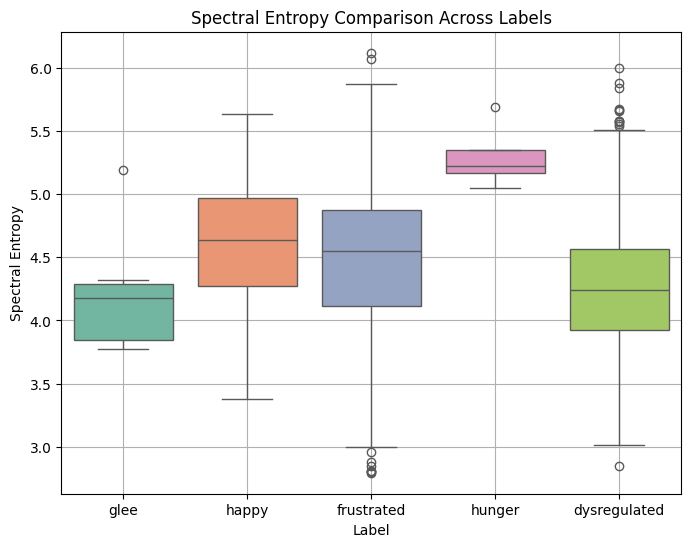

In [112]:
t_test_results = pairwise_t_test(df, target_labels=["glee", "happy", "frustrated", "hunger", "dysregulated"], feature="Spectral Entropy")
format_t_test_results(t_test_results)
plot_spectral_entropy_comparison(df, target_labels=["glee", "happy", "frustrated", "hunger", "dysregulated"])